In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
sns.set(context="notebook", style="ticks", font="Helvetica")
import numpy as np

In [2]:
datasets = sorted([
    "somatosensory_converted_into_tpm",
    "Dopaminergic_TPM_clean",
    "kakadarov_tpm",
    "Cheng_ES_TPM",
    "Gaublomme_GSE75109_TPM_clean",
    "Gaublomme_GSE75110_TPM_clean",
    "Gaublomme_GSE75111_TPM_clean",
    "Rbp4_positive_cells",
    "Alveolar_cells_Type_I_Merged_Batches",
    "Alveolar_cells_Type_II_Merged_Batches",
    "klein",
    "hepat_TPM_yang_clean",
    "Yu_First_wave_endocrine_cells",
])

In [3]:
cell_type_names = {
    "somatosensory_converted_into_tpm": "Somatosensory N",
    "Dopaminergic_TPM_clean": "Dopaminergic N",
    "kakadarov_tpm": "CD8+ T cell",
    "Cheng_ES_TPM": "Isolated ESC",
    "Gaublomme_GSE75109_TPM_clean": "Th17 A",
    "Gaublomme_GSE75110_TPM_clean": "Th17 B",
    "Gaublomme_GSE75111_TPM_clean": "Th17 C",
    "Rbp4_positive_cells": "Corticostriatal N",
    "Alveolar_cells_Type_I_Merged_Batches": "Lung ACI",
    "Alveolar_cells_Type_II_Merged_Batches": "Lung ACII",
#     "Alveolar_cells_both_types",
    "klein": "Cultured ESC",
    "hepat_TPM_yang_clean": "Liver HB/HC",
    "Yu_First_wave_endocrine_cells": "Pancreatic EC",
}

In [4]:
def load_pvalues():
    dfs = [pd.read_csv("{}/family_stat_test_pvalues.csv".format(x), header=[0,1], index_col=[0]) for x in datasets] 
    for i, dataset in enumerate(datasets):
        dfs[i].loc[:,"dataset"] = dataset
    df = pd.concat(dfs)
    return df.rename({"Unnamed: 1_level_0": "", "Unnamed: 2_level_0": ""}, axis=1)

In [5]:
df = load_pvalues()
df.set_index("dataset").to_csv("family_stats_test_summary.csv")

In [6]:
df = df.loc[df.iloc[:,0] == 7].replace(cell_type_names)

In [7]:
cutoff=-np.log2(0.025)
cutoff

5.321928094887363

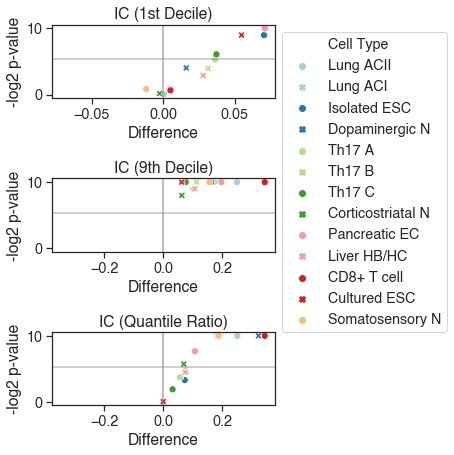

In [15]:
current_palette = sns.color_palette("Paired", n_colors=7)
new_palette = []
for x in current_palette:
    new_palette += [x,x]
new_palette = new_palette[:13]

def plot_volcano(metric, title, ax, legend=False):
    sns.set(font_scale=1.3, style="ticks", font="Arial")
    _df = df.set_index("dataset").loc[:,metric].reset_index().rename({"dataset": "Cell Type"}, axis=1)
    _df.loc[:,"Difference"] = (_df.Original - _df.Shuffled)
    _df.loc[:,"-log2 p-value"] = -np.log2(_df.loc[:,"P-value"])
    sns.set(font_scale=1.3, style="ticks", font="Helvetica")
    filled_markers = ['o', 'X']*7
    sns.scatterplot(data=_df,x="Difference",y="-log2 p-value",hue="Cell Type",style="Cell Type",markers=filled_markers,palette=new_palette,legend=legend,s=50,ax=ax)
    xlim = max(_df.Difference.max(),_df.Difference.min())*1.1
    sns.lineplot([-xlim,xlim],[cutoff, cutoff],dashes=True,color="grey", alpha=0.5,ax=ax)
    sns.distplot([0], kde=False, hist=False, rug=True, rug_kws={"height": 1.0, "linewidth": 2, "alpha": 0.5, "color": "grey"},ax=ax)
    ax.set_xlim([-xlim,xlim])
    if legend:
        ax.legend(bbox_to_anchor=(1.0, 1.0))
    ax.set_title(title)
    
_, axs = plt.subplots(3,1,figsize=(4,7))
plt.subplots_adjust(hspace=1.1)
plot_volcano("10%", "IC (1st Decile)", axs[0], legend="full")
plot_volcano("90%", "IC (9th Decile)", axs[1])
plot_volcano("Quantile Ratio", "IC (Quantile Ratio)", axs[2])
plt.show()


7     Corticostriatal N
8         Pancreatic EC
12      Somatosensory N
Name: Cell Type, dtype: object

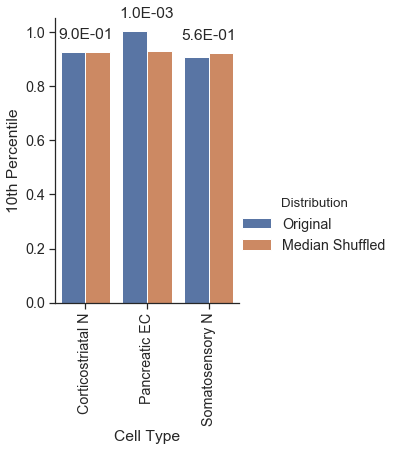

In [12]:
def transform(df):
    orig = pd.DataFrame([[df.Original.iloc[0]]], columns=["value"])
    shuf = pd.DataFrame([[df.Shuffled.iloc[0]]], columns=["value"])
#     orig.columns = ["metric", "value"]
#     shuf.columns = ["metric", "value"]
    orig.loc[:,"Distribution"] = "Original"
    shuf.loc[:,"Distribution"] = "Median Shuffled"
    
    return pd.concat([orig, shuf])

def draw_pvalues(ax, x, dataset, metric):
    _df = df.set_index("dataset").loc[:,metric]
    y = _df.loc[dataset,["Original", "Shuffled"]].max()
    pvalue = _df.loc[dataset,"P-value"]
    ax.text(x, y+0.05, "{:.1E}".format(pvalue), horizontalalignment='center')

sns.set(font_scale=1.3, style="ticks", font="Arial")
_df = df.set_index("dataset").loc[:,"10%"].reset_index().rename({"dataset": "Cell Type"}, axis=1)
_df.loc[:,"Difference"] = _df.Original - _df.Shuffled
_datasets = _df.loc[[7,8,12],"Cell Type"]
_df = _df.iloc[[7,8,12]].groupby("Cell Type").apply(transform).reset_index()
g = sns.catplot(data=_df, x="Cell Type", y="value", hue="Distribution", kind="bar", sharey=False, aspect=0.8)
plt.xticks(rotation = 90)
plt.ylabel("10th Percentile")
plt.xlabel("Cell Type")
for x, name in enumerate(_datasets):
    draw_pvalues(g.ax, x, name, "10%")
_datasets